# Bias–Variance Tradeoff: An Intuitive Demonstration

This notebook provides an intuitive, empirical demonstration of the bias–variance tradeoff.

Rather than focusing on formulas, the goal is to understand how model complexity
affects generalization by:
- training many models on independently sampled noisy datasets,
- visualizing their predictions,
- and explicitly computing bias and variance.


## Problem setup

We consider a simple regression problem with a known true function:

\[
y = \sin(x)
\]

Training data are generated by sampling points from this function and adding
Gaussian noise. Because the true function is known, we can explicitly study
bias and variance.


In [25]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

rng = np.random.default_rng(42)

In [26]:
def f_true(x):
    return np.sin(x)

def sample_dataset(n=30, noise_sd=0.3):
    X = rng.uniform(0, 6, size=n)
    y = f_true(X) + rng.normal(0, noise_sd, size=n)
    return X.reshape(-1, 1), y

In [27]:
x_grid = np.linspace(0, 6, 100).reshape(-1, 1)
y_true_grid = f_true(x_grid.ravel())

print("x_grid shape:", x_grid.shape)

x_grid shape: (100, 1)


In [28]:
def fit_and_predict(degree, n_datasets=200, n=30, noise_sd=0.3):
    model = make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=True),
        LinearRegression()
    )

    preds = []
    for _ in range(n_datasets):
        X_train, y_train = sample_dataset(n=n, noise_sd=noise_sd)
        model.fit(X_train, y_train)
        y_hat = model.predict(x_grid)
        preds.append(y_hat)

    return np.array(preds)

## Bias and variance from predictions

Let \(\hat{y}_m(x)\) be the prediction of the \(m\)-th model at input \(x\).

From the prediction matrix `preds`:
- **mean prediction**: \(\mathbb{E}[\hat{y}(x)]\) (average over models)
- **bias**: \(\mathbb{E}[\hat{y}(x)] - f(x)\)
- **variance**: \(\mathrm{Var}(\hat{y}(x))\) (variation across models)

We report:
- \( \text{bias}^2 \) averaged over the input grid,
- variance averaged over the input grid.


In [29]:
def bias_variance_from_preds(preds, y_true):
    mean_pred = preds.mean(axis=0)          # E_model[ y_hat(x) ] for each x on the grid
    bias = mean_pred - y_true               # bias(x)
    bias2 = (bias ** 2).mean()              # average over x
    var = preds.var(axis=0).mean()          # average over x of Var_model[ y_hat(x) ]
    return bias2, var

## Effect of model complexity

We first evaluate a low-complexity model (polynomial degree = 1),
which is expected to underfit the true function.
We then increase model complexity to study its effect on bias and variance.


Degree 1 -> Bias^2: 0.1780431540951421
Degree 1 -> Variance: 0.023233361486720342


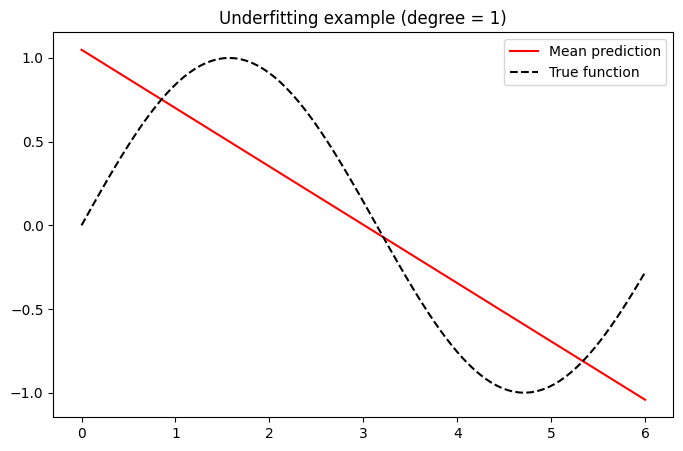

In [30]:
preds_deg1 = fit_and_predict(degree=1, n_datasets=200, n=30, noise_sd=0.3)
bias2_1, var_1 = bias_variance_from_preds(preds_deg1, y_true_grid)

print("Degree 1 -> Bias^2:", bias2_1)
print("Degree 1 -> Variance:", var_1)

mean_pred_1 = preds_deg1.mean(axis=0)

plt.figure(figsize=(8, 5))
plt.plot(x_grid.ravel(), mean_pred_1, color="red", label="Mean prediction")
plt.plot(x_grid.ravel(), y_true_grid, color="black", linestyle="--", label="True function")
plt.legend()
plt.title("Underfitting example (degree = 1)")
plt.show()

## Increasing model complexity

The linear model (degree = 1) fails to capture the nonlinear structure of the data,
resulting in high bias and systematic deviation from the true function.

To reduce bias, we increase model complexity by allowing nonlinear transformations
of the input via higher-degree polynomial features.
We now evaluate a polynomial model of degree 3.

In [31]:
preds = fit_and_predict(degree=3, n_datasets=200, n=30, noise_sd=0.3)

print("preds shape:", preds.shape)
print("first row, first 5 values:", preds[0][:5])


preds shape: (200, 100)
first row, first 5 values: [-0.42122206 -0.30802771 -0.20091072 -0.09975344 -0.00443823]


In [32]:
bias2, var = bias_variance_from_preds(preds, y_true_grid)

print("Degree 3 -> Bias^2:", bias2)
print("Degree 3 -> Variance:", var)
print("Noise variance (sigma^2):", 0.3 ** 2)

Degree 3 -> Bias^2: 0.0039284412155516655
Degree 3 -> Variance: 0.016784311961132094
Noise variance (sigma^2): 0.09


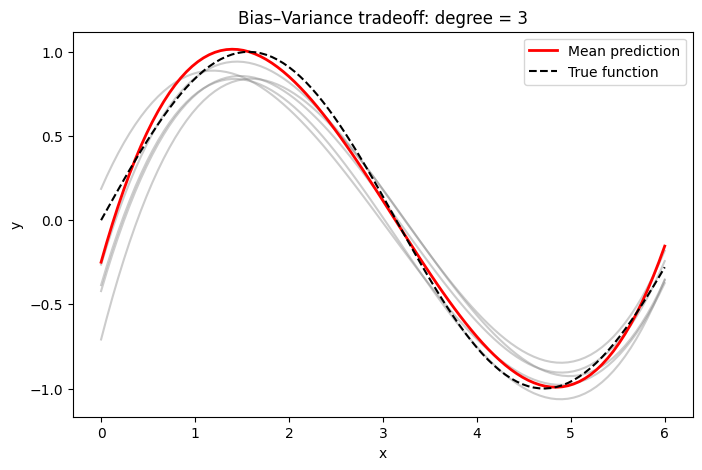

In [33]:
mean_pred = preds.mean(axis=0)

plt.figure(figsize=(8, 5))

# individual models
for i in range(5):
    plt.plot(x_grid.ravel(), preds[i], color="gray", alpha=0.4)

# mean prediction
plt.plot(
    x_grid.ravel(),
    mean_pred,
    color="red",
    linewidth=2,
    label="Mean prediction"
)

# true function
plt.plot(
    x_grid.ravel(),
    y_true_grid,
    color="black",
    linestyle="--",
    label="True function"
)

plt.legend()
plt.title("Bias–Variance tradeoff: degree = 3")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Key takeaway

Increasing model complexity from degree 1 to degree 3 significantly reduces bias
while keeping variance under control. Beyond this point, further increases in
complexity would mainly increase variance without substantial bias reduction.